In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import cv2
from keras.preprocessing.image import ImageDataGenerator
import time
from tqdm import tqdm
from IPython import display

In [2]:
#data_dir = 'W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training\Original Images'
data_dir = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training\Black and White Original- 16x Subset"
image_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.JPG')]
images = []
for img_path in image_paths:
    image = mpimg.imread(img_path)
    images.append(image)
images = (np.array(images) -127.5) / 127.5

In [3]:
images.shape

(26, 1536, 2304)

In [4]:
BATCH_SIZE = 4
train_dataset = tf.data.Dataset.from_tensor_slices(images)
train_dataset = train_dataset.shuffle(32)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [5]:
latent_dim = 100
height = 384 *4
width = 576 *4
channels = 1

In [6]:
# Generator model
generator_inputs = keras.Input(shape = (latent_dim,))

x = layers.Dense(128 * 24 * 16 * 36)(generator_inputs)
x = layers.LeakyReLU()(x)
x = layers.Reshape((24*4, 36*4, 128))(x)

x = layers.Conv2DTranspose(512, kernel_size=2, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, kernel_size=2, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(128, kernel_size=2, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(64, kernel_size=2, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

generator_outputs = layers.Conv2DTranspose(1, kernel_size=5, strides=1, padding='same', activation='tanh')(x)
generator = keras.Model(generator_inputs, generator_outputs, name='generator')


In [7]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 1769472)           178716672 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1769472)           0         
                                                                 
 reshape (Reshape)           (None, 96, 144, 128)      0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 192, 288, 512)     262656    
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 192, 288, 512)     2048      
 Normalization)                                          

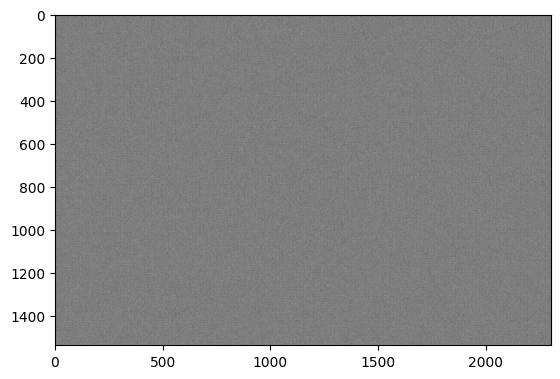

In [8]:
noise = tf.random.normal([1,100])
generated_image = generator(noise, training= False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [9]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=[height, width, channels]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [10]:
discriminator = discriminator_model()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 768, 1152, 64)     1664      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 768, 1152, 64)     0         
                                                                 
 dropout (Dropout)           (None, 768, 1152, 64)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 384, 576, 128)     204928    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 384, 576, 128)     0         
                                                                 
 dropout_1 (Dropout)         (None, 384, 576, 128)     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 192, 288, 256)     8

In [11]:
print(discriminator(generated_image))

tf.Tensor([[0.50000185]], shape=(1, 1), dtype=float32)


In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
EPOCHS = 6000
noise_dim = 100
num_examples_to_generate = 4
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [16]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [17]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training = False)
    fig = plt.figure(figsize=(2,2))

    print(predictions.shape)
    for i in range(predictions.shape[0]):
        plt.subplot(2, 2, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

In [18]:
model_location = "C:/Users/naresh\OneDrive - STERIS Corporation\Documents\models\GAN- 16x images"

In [19]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in tqdm(dataset):
            train_step(image_batch)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)

        print('Time for epoch {} is {}'.format(epoch+1, time.time() - start))

        if epoch > 50 and (epoch % 20) == 0:
            generator.save(model_location + '/' + str(epoch) + '.h5')

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)

(4, 1536, 2304, 1)


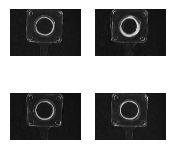

Time for epoch 2953 is 232.4895896911621


 14%|█▍        | 1/7 [01:04<06:28, 64.71s/it]


KeyboardInterrupt: 

: 

In [20]:
train(train_dataset, EPOCHS)

In [ ]:
generator.save(model_location + '/' + str(EPOCHS) + ".h5")

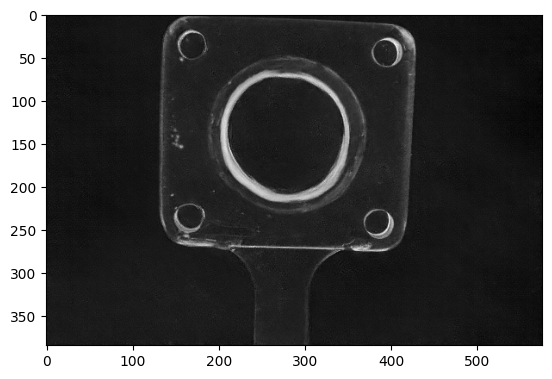

In [ ]:
noise = tf.random.normal([BATCH_SIZE, noise_dim])
generatedImg = generator(noise, training=False)[0, :, :, 0]
plt.imshow(generatedImg, cmap='gray')

In [ ]:
from tensorflow.keras.models import load_model
from keras.preprocessing import image

In [ ]:
newmodel = load_model(model_location + '/6000.h5')

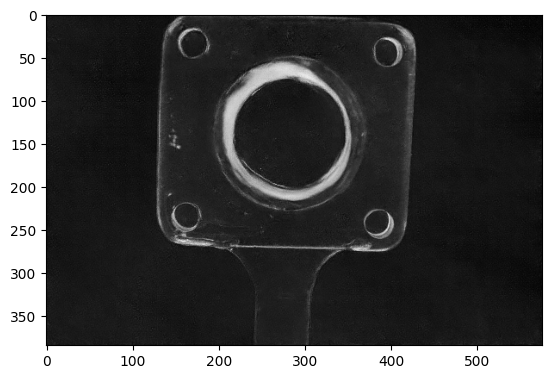

In [ ]:
noise = tf.random.normal([BATCH_SIZE, noise_dim])
plt.imshow(newmodel(noise, training=False)[0, :, :, 0], cmap='gray')